<a href="https://colab.research.google.com/github/Xanadum/project/blob/main/project2-task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Input and output size of the neural network:
   - Input size: 1
   - Output size: 1

2. Neural network implementation with specified weights (see code above)

3. Computing approximation errors for various p values:
p = 2, Approximation Error = 0.0156000033
p = 3, Approximation Error = 0.0038999990
p = 4, Approximation Error = 0.0009750277
p = 5, Approximation Error = 0.0002437532
p = 6, Approximation Error = 0.0000609457
p = 7, Approximation Error = 0.0000152513
p = 8, Approximation Error = 0.0000038147
p = 9, Approximation Error = 0.0000009686
p = 10, Approximation Error = 0.0000002533

4. Plotting approximate solutions against the true solution for p = 2, 4, 8:


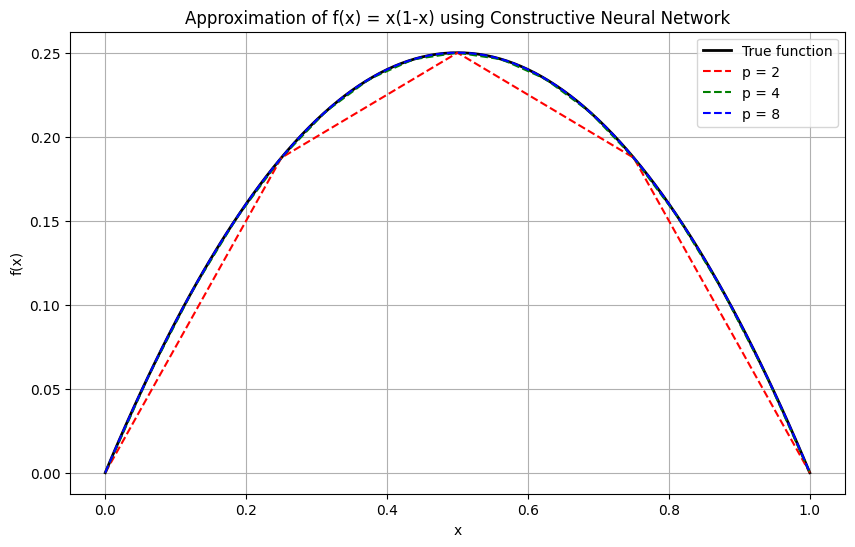


5. Plotting the log of approximation error vs p and comparing to theoretical rate:


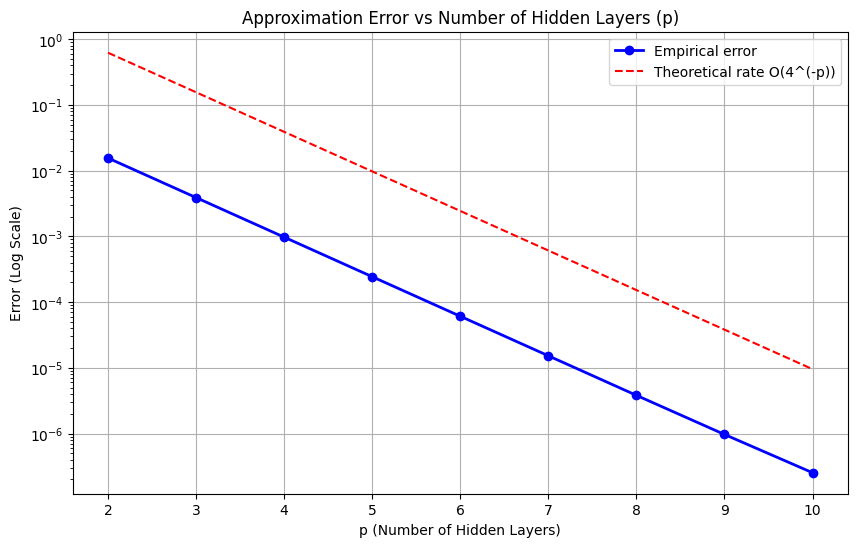

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class ConstructiveNetwork(nn.Module):
    def __init__(self, p=3):
        """
        Initialize the neural network with p hidden layers

        Args:
            p (int): Number of hidden layers (plus output layer)
        """
        super(ConstructiveNetwork, self).__init__()
        self.p = p

        # Create layers list to hold all layers
        self.layers = nn.ModuleList()

        # First layer (layer 0)
        layer0 = nn.Linear(1, 3)
        with torch.no_grad():
            # Set W0
            layer0.weight.copy_(torch.tensor([[1.0], [1.0], [0.0]]))
            # Set b0
            layer0.bias.copy_(torch.tensor([0.0, -0.5, 0.0]))
        self.layers.append(layer0)

        # Hidden layers (layer 1 to p-1)
        for r in range(1, p):
            layer = nn.Linear(3, 3)
            with torch.no_grad():
                # Set Wr
                factor = 4.0 ** r
                layer.weight.copy_(torch.tensor([
                    [2.0, -4.0, 0.0],
                    [2.0, -4.0, 0.0],
                    [2.0/factor, -4.0/factor, 1.0]
                ]))
                # Set br
                layer.bias.copy_(torch.tensor([0.0, -0.5, 0.0]))
            self.layers.append(layer)

        # Output layer (layer p)
        output_layer = nn.Linear(3, 1)
        with torch.no_grad():
            # Set Wp
            factor_p = 4.0 ** p
            output_layer.weight.copy_(torch.tensor([[2.0 * (4.0 ** -p), -4.0 * (4.0 ** -p), 1.0]]))
            # Set bp
            output_layer.bias.copy_(torch.tensor([0.0]))
        self.layers.append(output_layer)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Output of the network
        """
        # Layer 0
        x = self.layers[0](x)
        x = self.relu(x)

        # Hidden layers with ReLU activation
        for i in range(1, self.p):
            x = self.layers[i](x)
            x = self.relu(x)

        # Output layer (linear activation)
        x = self.layers[self.p](x)

        return x

def true_function(x):
    """Compute the true function value f(x) = x(1-x)"""
    return x * (1 - x)

def compute_errors(p_values):
    """
    Compute approximation errors for different p values

    Args:
        p_values (list): List of p values to evaluate

    Returns:
        dict: Dictionary mapping p values to their approximation errors
    """
    # Create grid of input values
    x_grid = torch.linspace(0, 1, 101).view(-1, 1)

    # Compute true values
    true_values = true_function(x_grid)

    errors = {}

    for p in p_values:
        # Create network with p hidden layers
        model = ConstructiveNetwork(p)

        # Evaluate the network (no need for training since weights are pre-defined)
        with torch.no_grad():
            predicted_values = model(x_grid)

        # Compute error in L-infinity norm
        error = torch.max(torch.abs(predicted_values - true_values)).item()
        errors[p] = error
        print(f"p = {p}, Approximation Error = {error:.10f}")

    return errors, x_grid, true_values

def plot_solutions(p_values, x_grid, true_values):
    """
    Plot approximate solutions against true solution

    Args:
        p_values (list): List of p values to plot
        x_grid (torch.Tensor): Grid of input values
        true_values (torch.Tensor): True function values
    """
    plt.figure(figsize=(10, 6))

    # Plot true function
    plt.plot(x_grid.numpy(), true_values.numpy(), 'k-', linewidth=2, label='True function')

    # Colors for different p values
    colors = ['r', 'g', 'b']

    for i, p in enumerate(p_values):
        model = ConstructiveNetwork(p)

        with torch.no_grad():
            predicted_values = model(x_grid)

        plt.plot(x_grid.numpy(), predicted_values.numpy(),
                 f'{colors[i]}--', linewidth=1.5, label=f'p = {p}')

    plt.title('Approximation of f(x) = x(1-x) using Constructive Neural Network')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)
    plt.savefig('approximation_comparison.png')
    plt.show()

def plot_error_rates(errors, p_values):
    """
    Plot log of approximation error against p

    Args:
        errors (dict): Dictionary mapping p values to their approximation errors
        p_values (list): List of p values evaluated
    """
    plt.figure(figsize=(10, 6))

    # Extract errors for plotting
    error_values = [errors[p] for p in p_values]

    # Plot error rates
    plt.semilogy(p_values, error_values, 'bo-', linewidth=2, label='Empirical error')

    # Plot theoretical rate O(4^(-p))
    theoretical_p = np.array(p_values)
    theoretical_error = 10 * (4.0 ** -theoretical_p)  # Constant factor for better visualization
    plt.semilogy(theoretical_p, theoretical_error, 'r--', linewidth=1.5,
             label='Theoretical rate O(4^(-p))')

    plt.title('Approximation Error vs Number of Hidden Layers (p)')
    plt.xlabel('p (Number of Hidden Layers)')
    plt.ylabel('Error (Log Scale)')
    plt.legend()
    plt.grid(True)
    plt.savefig('error_rate.png')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Define p values to evaluate
    p_values_all = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    p_values_plot = [2, 4, 8]

    # Print answer to part 1
    print("1. Input and output size of the neural network:")
    print("   - Input size: 1")
    print("   - Output size: 1")
    print("\n2. Neural network implementation with specified weights (see code above)")

    # Compute errors for part 3
    print("\n3. Computing approximation errors for various p values:")
    errors, x_grid, true_values = compute_errors(p_values_all)

    # Part 4: Plot solutions for p = 2, 4, 8
    print("\n4. Plotting approximate solutions against the true solution for p = 2, 4, 8:")
    plot_solutions(p_values_plot, x_grid, true_values)

    # Part 5: Plot error rates
    print("\n5. Plotting the log of approximation error vs p and comparing to theoretical rate:")
    plot_error_rates(errors, p_values_all)